In [1]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

In [4]:
data = input_data.read_data_sets('data/fashion', one_hot=True,\
    source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
xTrain = data.train.images.reshape(-1,28,28,1)
yTrain = data.train.labels
xTest = data.test.images.reshape(-1,28,28,1)
yTest = data.test.labels
print(xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',\
    6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle-boot'}

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1) (55000, 10) (10000, 28, 28, 1) (10000, 10)


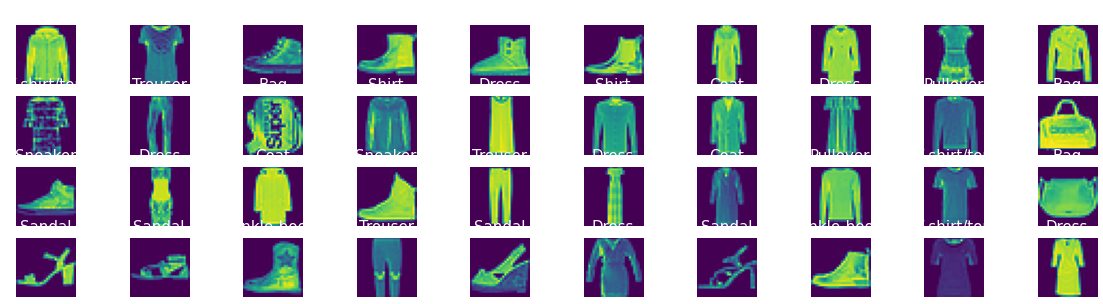

In [5]:
plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4,10,1+i)
    plt.imshow( xTrain[i].reshape(28,28) )
    plt.title( label_dict[np.argmax(yTrain[i,:])], c='white', fontSize=15)
    plt.axis('off')
plt.show()

In [6]:
batch_size = 128
x = tf.placeholder("float", [None, 28,28,1], name='inputL')
y = tf.placeholder("float", [None, len(label_dict)])

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(128,len(label_dict)), initializer=tf.contrib.layers.xavier_initializer()),
} # tf.get_variable(name,shape,initializer)
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

def conv_net(x, weights, biases):
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=2)
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'], name='outputL')
    return out

In [7]:
pred = conv_net(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    summary_writer = tf.summary.FileWriter('./board', sess.graph)
    for i in range(3):
        for batch in range(len(xTrain)//batch_size):
            xBatch = xTrain[batch*batch_size:min((batch+1)*batch_size,len(xTrain))]
            yBatch = yTrain[batch*batch_size:min((batch+1)*batch_size,len(yTrain))]    
            opt = sess.run(optimizer, feed_dict={x:xBatch, y:yBatch})
            loss, acc = sess.run([cost, accuracy], feed_dict={x:xBatch, y:yBatch})
        valLoss, valAcc,  = sess.run([cost, accuracy], feed_dict={x:xTest, y:yTest})
        print("Epoch={}, Loss={:.4f}, Acc={:.4f}, valLoss={:.4f}, valAcc={:.4f}".format(\
            i,loss,acc,valLoss,valAcc))
        train_loss.append(loss)
        test_loss.append(valLoss)
        train_accuracy.append(acc)
        test_accuracy.append(valAcc)
    summary_writer.close()
    
    frozen_graph = tf.graph_util.convert_variables_to_constants(
        sess, tf.get_default_graph().as_graph_def(), ['outputL'])
    tf.io.write_graph(frozen_graph, "./pb/", "frozen_model.pb", as_text=False)
    tf.io.write_graph(frozen_graph, "./pbtxt/", "frozen_model.pbtxt", as_text=True)

Epoch=0, Loss=0.3190, Acc=0.8828, valLoss=0.4164, valAcc=0.8462
Epoch=1, Loss=0.2409, Acc=0.9062, valLoss=0.3522, valAcc=0.8706
Epoch=2, Loss=0.1848, Acc=0.9297, valLoss=0.3091, valAcc=0.8873
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


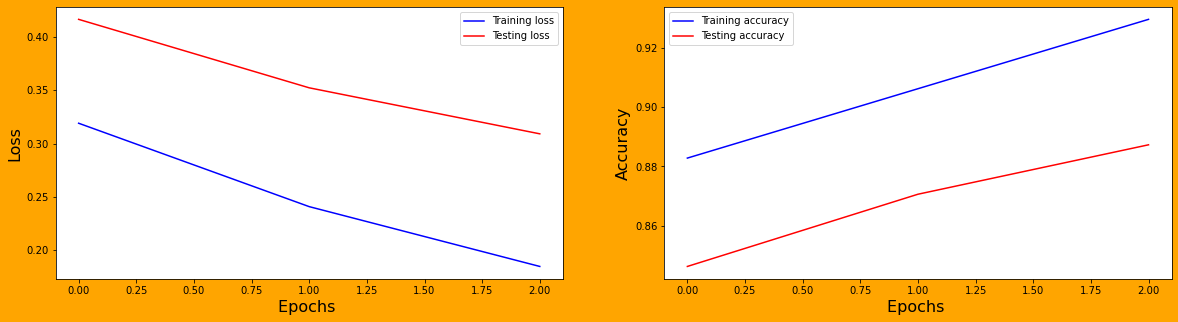

In [9]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('orange')

plt.subplot(1,2,1)
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.legend(labels=['Training loss', 'Testing loss'])
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'b')
plt.plot(test_accuracy, 'r')
plt.legend(labels=['Training accuracy', 'Testing accuracy'])
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.show()

In [ ]:
!tensorboard --logdir board

In [10]:
with tf.gfile.GFile("pb/frozen_model.pb", "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as graph:
    with tf.Session() as sess:
        tf.import_graph_def(graph_def, name='')
        graph = tf.get_default_graph()              # print(graph.get_operations())
        x = graph.get_tensor_by_name('inputL:0')
        out = graph.get_tensor_by_name('outputL:0')
        
        result = sess.run(out, feed_dict={x: xTest[:20]})
        predLabel = np.argmax(result, axis=1)
        trueLabel = np.argmax(yTest[:20], axis=1)
        for i in range(20):
            print(label_dict[predLabel[i]], label_dict[trueLabel[i]])

Ankle-boot Ankle-boot
Pullover Pullover
Trouser Trouser
Trouser Trouser
Shirt Shirt
Trouser Trouser
Coat Coat
Shirt Shirt
Sandal Sandal
Sneaker Sneaker
Coat Coat
Sandal Sandal
Sandal Sneaker
Dress Dress
Coat Coat
Trouser Trouser
Pullover Pullover
Coat Coat
Bag Bag
T-shirt/top T-shirt/top
